In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from budget_simulation_tool import ConstantItem, DiscreteItem, ContinuousItem, Budget

# Create our items

Each item represents a cashflow, which can be an income or expense.

## Types of cashflows
There are three types of cashflows:
- `ConstantItem`: A constant cashflow:
    - This is a cashflow that is not expected to vary by time.
    - For example, perhaps your gym membership or your internet bill is a fixed amount per month and this is not expected to change.
- `DiscreteItem`: A cash flow that can take a finte amount of scenarios:
    - This is a cash flow that may vary from time to time, but can only take a finite number of possible values.
    - For example, income from employment may have 3 states: `current job, promotion, and unemployed`
- `ContinuousItem`: A cash flow that can take any number of scenarios:
    - This is a cash flow that can take virtually any value.
    - For example, your grocery bill is a continuous variable.
<br><br>

    | NOTE: As we will see, there is nothing stopping us from using `ContinuousItem` for discrete items. The callable is arbitrary so one can certainly use, for example, `np.random.poisson` as the value generating function.|
    | --- |

## Markov Chains
`budget_simulation_tool` also allows next states to depend on the prior state, like a markov chain.

In budgeting, a cashflow's value can often depend on its prior state. For example, if you currently have a job, you are likely to have a job next month. Similarly, perhaps your electricity bill will be autocorrelated because of electricity costs, temperature, etc.

To incorporate this in your budget simulation, you can either use a markov chain for `DiscreteItem`s, or a callable that takes a prior value as an input for `ContinuousItem`s. Examples are provided below


Enough said. Let's look at an example:

# Example

## Establishing the cash flow items

In [20]:
# Constant Item
gym_membership = ConstantItem(
    'gym_membership',
    -5
)

# Discrete Item, does not depend on prior
car_maintenance = DiscreteItem(
    'car_maintenance',
    {'small_item': -5, 'big_item': -30, 'both': -35, 'no_maintenance': 0},
    [0.1, 0.05, 0.01, 0.84]
)
    

# Discrete Item, depends on prior
employment_income = DiscreteItem(
    'employment_income',
    {'cushy_job': 100, 'startup': 80, 'IPO': 1000, 'jobless': 0},
    [
        [0.95, 0.0, 0.0, 0.05],
        [0.1, 0.8, 0.05, 0.05],
        [0.0, 0.0, 0.80, 0.20],
        [0.70, 0.0, 0.0, 0.30]
        ],
    init = 'startup'
    )

# Continuous Item, does not depend on prior
groceries = ContinuousItem(
    'groceries',
    lambda: -np.random.exponential(20),
    )

# Continuous Item, depends on prior
utilities = ContinuousItem(
    'utilities',
    lambda prior: min(-np.random.normal(abs(prior)), 0),
    init = -10
    )

## Creating and simulating our budget

,gym_membership,car_maintenance,employment_income,groceries,utilities,total
count,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-60.0,-28.365000,1116.800000,-240.228962,-731.661102,56.544936
std,0.0,25.315858,109.771626,68.371683,416.296179,431.900355
min,-60.0,-140.000000,600.000000,-494.059290,-1606.139516,-951.161374
25%,-60.0,-40.000000,1100.000000,-283.389418,-1107.536063,-297.061904
50%,-60.0,-30.000000,1200.000000,-233.951189,-732.204840,33.209072
75%,-60.0,-5.000000,1200.000000,-189.385230,-345.297645,421.298922
max,-60.0,0.000000,1200.000000,-82.281596,-5.187069,952.168322


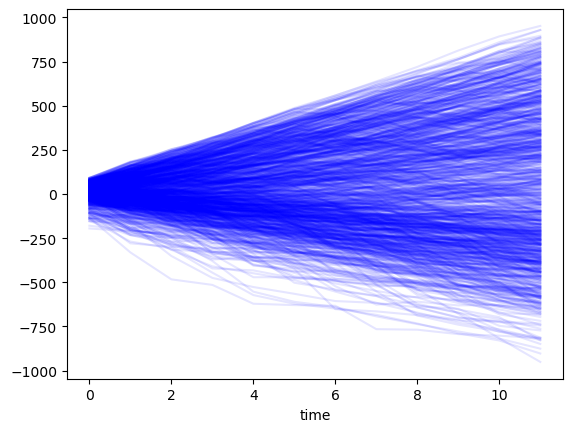

In [21]:
fig, ax = plt.subplots()

cumulative_in_a_year = None

for simulations in range(1000):
    budget = Budget(
        gym_membership,
        car_maintenance,
        employment_income,
        groceries,
        utilities
    )

    budget_states, budget_values = budget.simulate(n=12)
    # get the cumulative value after a year
    cum_budet_values = budget_values.cumsum(axis = 0)
    cum_budet_values.sum(axis = 1).plot(ax = ax, alpha = 0.1, c = 'b')
    
    if cumulative_in_a_year is None:
        cumulative_in_a_year = cum_budet_values.iloc[[-1]]
    else:
        cumulative_in_a_year = pd.concat([cumulative_in_a_year, cum_budet_values.iloc[[-1]]], axis = 0)

# sum across all cash flow items
cumulative_in_a_year['total'] = cumulative_in_a_year.sum(axis = 1)
# rename index
cumulative_in_a_year.index.name = 'simulation'
cumulative_in_a_year.index = range(len(cumulative_in_a_year))

cumulative_in_a_year.describe()